In [56]:
from LSV1M_training.load_best_models import load_best_brcnn_model, load_best_energy_model
from nnvision.utility.measures import get_correlations
import matplotlib.pyplot as plt
import numpy as np
from create_mei import create_mei_of_n_neurons
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sns
from check_LSV1M_model.classical_exps_config import radii


/home/baroni/recnn/src/neuralpredictors/neuralpredictors/layers/readouts/base.py:74: UserWarning: Use of 'gamma_readout' is deprecated. Use 'feature_reg_weight' instead. If 'feature_reg_weight' is defined, 'gamma_readout' is ignored
  warnings.warn(
/home/baroni/recnn/old_code/readout.py:323: UserWarning: sigma is sampled from uniform distribution, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


## get correlations

In [2]:
model0, dataloaders0 = load_best_brcnn_model(neurons_subset='0', return_dataloaders=True)
model1, dataloaders1 = load_best_brcnn_model(neurons_subset='1', return_dataloaders=True)

loading data
preprocessing data
loading test data
preprocessing test data


/home/baroni/recnn/src/neuralpredictors/neuralpredictors/layers/readouts/base.py:74: UserWarning: Use of 'gamma_readout' is deprecated. Use 'feature_reg_weight' instead. If 'feature_reg_weight' is defined, 'gamma_readout' is ignored
  warnings.warn(
/home/baroni/recnn/old_code/readout.py:323: UserWarning: sigma is sampled from uniform distribution, instead of a fixed value. Consider setting fixed_sigma to True
  warnings.warn(


loading data
preprocessing data
loading test data
preprocessing test data


In [3]:
corr_0_brcnn = get_correlations(model0, dataloaders0['test'], as_dict=False, per_neuron=False, device='cuda')
corr_1_brcnn = get_correlations(model1, dataloaders1['test'], as_dict=False, per_neuron=False, device='cuda')

In [34]:
# energy_model0 = load_best_energy_model(neurons_subset='0', return_dataloaders=False)
#%%
import torch
import numpy as np
import random
from models import BRCNN_no_scaling, EnergyModel
from pickle_utils import pickleread
from LSV1M_training.dataset import get_LSV1M_dataloaders, get_LSV1M_empty_dataloaders
from LSV1M_training.LSV1M_utils import (
    set_random_seeds, 
    get_neuron_indices, 
    get_population_indices,
    get_positions_and_orientations,
    set_brcnn_positions
)

def load_best_energy_model(population='both', dataloaders_batch_size=300, dataloaders_n_images_val=5000, neurons_subset='0', return_dataloaders=False):
    """Load the best energy model checkpoint and configure it."""
    
    set_random_seeds()
    d = torch.load('/home/baroni/recnn/LSV1M_training/saved_models/em__model_checkpoint_20250117_135034.pth')
    model_config = d['model_config']
    model_state_dict = d['model_state_dict']
    ######## Load checkpoint ###########
    # checkpoint = torch.load('dummy_path/model_checkpoint.pth') #TODO FIX PATH
    # model_config = checkpoint['config']
    # model_state_dict = checkpoint['model_state_dict']

    # Get neuron indices
    exc_neuron_idxs, inh_neuron_idxs = get_neuron_indices(neurons_subset)
    neuron_idxs = get_population_indices(population, exc_neuron_idxs, inh_neuron_idxs)
    # Get dataloaders
    dataloader_fn = get_LSV1M_dataloaders if return_dataloaders else get_LSV1M_empty_dataloaders
    dataloaders = dataloader_fn(
        population=population,
        batch_size=dataloaders_batch_size,
        n_images_val=dataloaders_n_images_val,
        exc_neuron_idxs=exc_neuron_idxs,
        center_input=True, #NOTE this is different from the BRCNN model
        inh_neuron_idxs=inh_neuron_idxs
    )

    # Get positions and orientations
    pos1, pos2, ori = get_positions_and_orientations('/CSNG/baroni/Dic23data/pos_and_ori.pkl', neuron_idxs)

    # Update model config
    model_config.update({
        'positions_x': -pos2, 
        'positions_y': pos1,
        'orientations': -ori
    })

    # Initialize and load model
    model = EnergyModel(dataloaders, seed=0, **model_config)
    model.cuda()
    if neurons_subset == '0':
        model.load_state_dict(model_state_dict)
    else:
        shared_params_state_dict = {k:v for k,v in model_state_dict.items() if k not in ['positions_x', 'positions_y', 'orientations', 'meshgrid_x', 'meshgrid_y']}
        model.load_state_dict(shared_params_state_dict, strict=False)

    model.eval()
    return (model, dataloaders) if return_dataloaders else model
energy_model0 = load_best_energy_model(neurons_subset='0', return_dataloaders=False)
energy_model1 = load_best_energy_model(neurons_subset='1', return_dataloaders=False)


n_neurons_dict {'all_sessions': 25000}
in_shapes_dict {'all_sessions': torch.Size([300, 1, 55, 55])}
input_channels [1]
n_neurons_dict {'all_sessions': 21875}
in_shapes_dict {'all_sessions': torch.Size([300, 1, 55, 55])}
input_channels [1]


In [35]:
corr_0_energy = get_correlations(energy_model0, dataloaders0['test'], as_dict=False, per_neuron=False, device='cuda')
corr_1_energy = get_correlations(energy_model1, dataloaders1['test'], as_dict=False, per_neuron=False, device='cuda')

In [38]:
import torch
correlation_d = {'0': corr_0_brcnn, '1': corr_1_brcnn, '0_energy': corr_0_energy, '1_energy': corr_1_energy}
print(correlation_d)
torch.save(correlation_d, './correlation_d.pth')


{'0': 0.6061856, '1': 0.6073027, '0_energy': 0.36123118, '1_energy': 0.36104938}


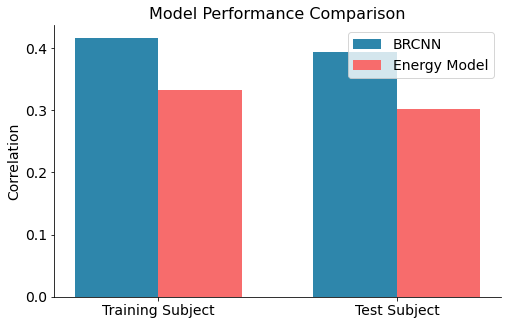

In [21]:
# plt.figure(figsize=(8,5))
# width = 0.35
# x = np.arange(2)

# plt.bar(x - width/2, [corr_0_brcnn, corr_1_brcnn], width, label='BRCNN', color='#2E86AB')
# plt.bar(x + width/2, [corr_0_energy, corr_1_energy], width, label='Energy Model', color='#F76C6C')

# plt.xticks(x, ['Training Subject', 'Test Subject'], fontsize=14)
# plt.ylabel('Correlation', fontsize=14)
# plt.legend(fontsize=14)
# plt.title('Model Performance Comparison', fontsize=16)
# plt.tick_params(axis='both', which='major', labelsize=14)

# # Remove top and right spines
# plt.gca().spines['top'].set_visible(False)
# plt.gca().spines['right'].set_visible(False)

# # Reduce number of y-axis ticks
# plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

# plt.show()


## get MEIS

Final f(x) = 2.77
Final f(x) = 2.88
Final f(x) = 2.77
Final f(x) = 3.69
Final f(x) = 3.94
Final f(x) = 3.87


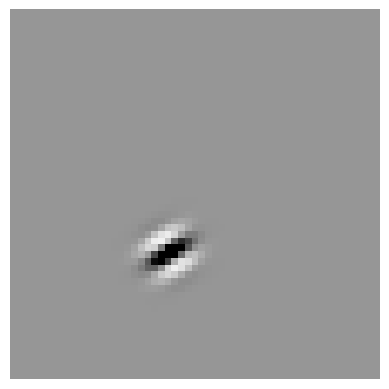

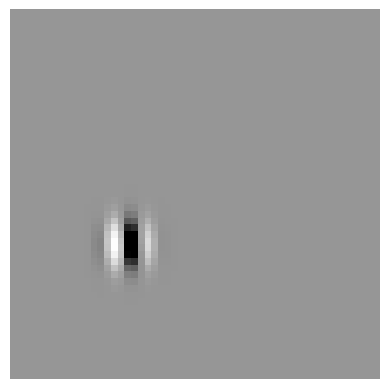

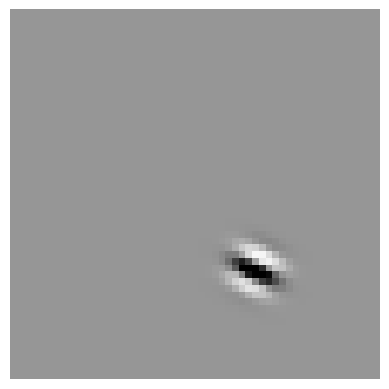

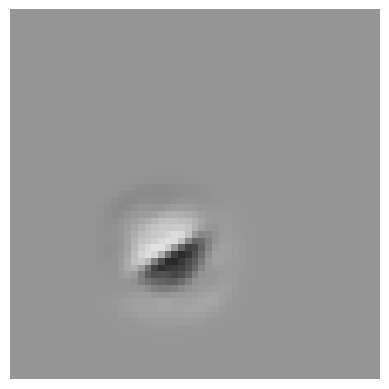

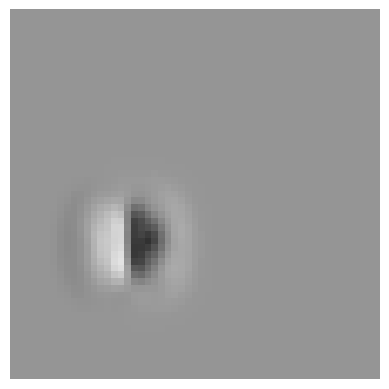

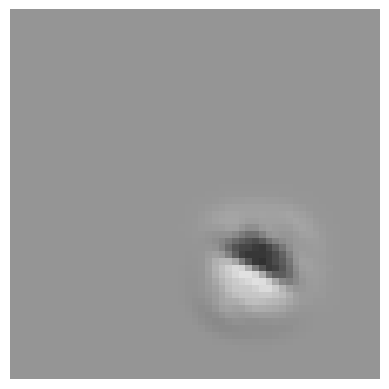

In [50]:
pixel_min = -1.8347# (the lowest value encountered in the data that served to train the model, serves as the black reference)
pixel_max = 2.1465 # (the highest [...] serves at white reference )
v_half = (pixel_max - pixel_min) / 2
img_res = [55,55]

mei_energy_config = {'std':0.15, 'seed':42, 'img_res': img_res, 'pixel_min': -v_half, 'pixel_max': v_half, 'gaussianblur':1., 'device':'cuda:1', 'step_size':10, 'num_steps':1000}
meis_energy, mei_acts_energy = create_mei_of_n_neurons(energy_model0, [0, 1, 2,], **mei_energy_config)

mei_config= {'std':0.15, 'seed':42, 'img_res': img_res, 'pixel_min': pixel_min, 'pixel_max': pixel_max, 'gaussianblur':1., 'device':'cuda:1', 'step_size':10, 'num_steps':1000}
meis_brcnn, mei_acts_brcnn = create_mei_of_n_neurons(model0, [0, 1, 2], **mei_config)
for i in range(3):
    plt.imshow(meis_energy[i], cmap='Greys_r', vmin = -v_half, vmax = v_half)
    plt.axis('off')
    plt.show()
for i in range(3):
    plt.imshow(meis_brcnn[i], cmap='Greys_r', vmin = pixel_min, vmax = pixel_max)
    plt.axis('off')
    plt.show()

In [51]:
torch.save(meis_energy, './meis_energy.pth')
torch.save(meis_brcnn, './meis_brcnn.pth')

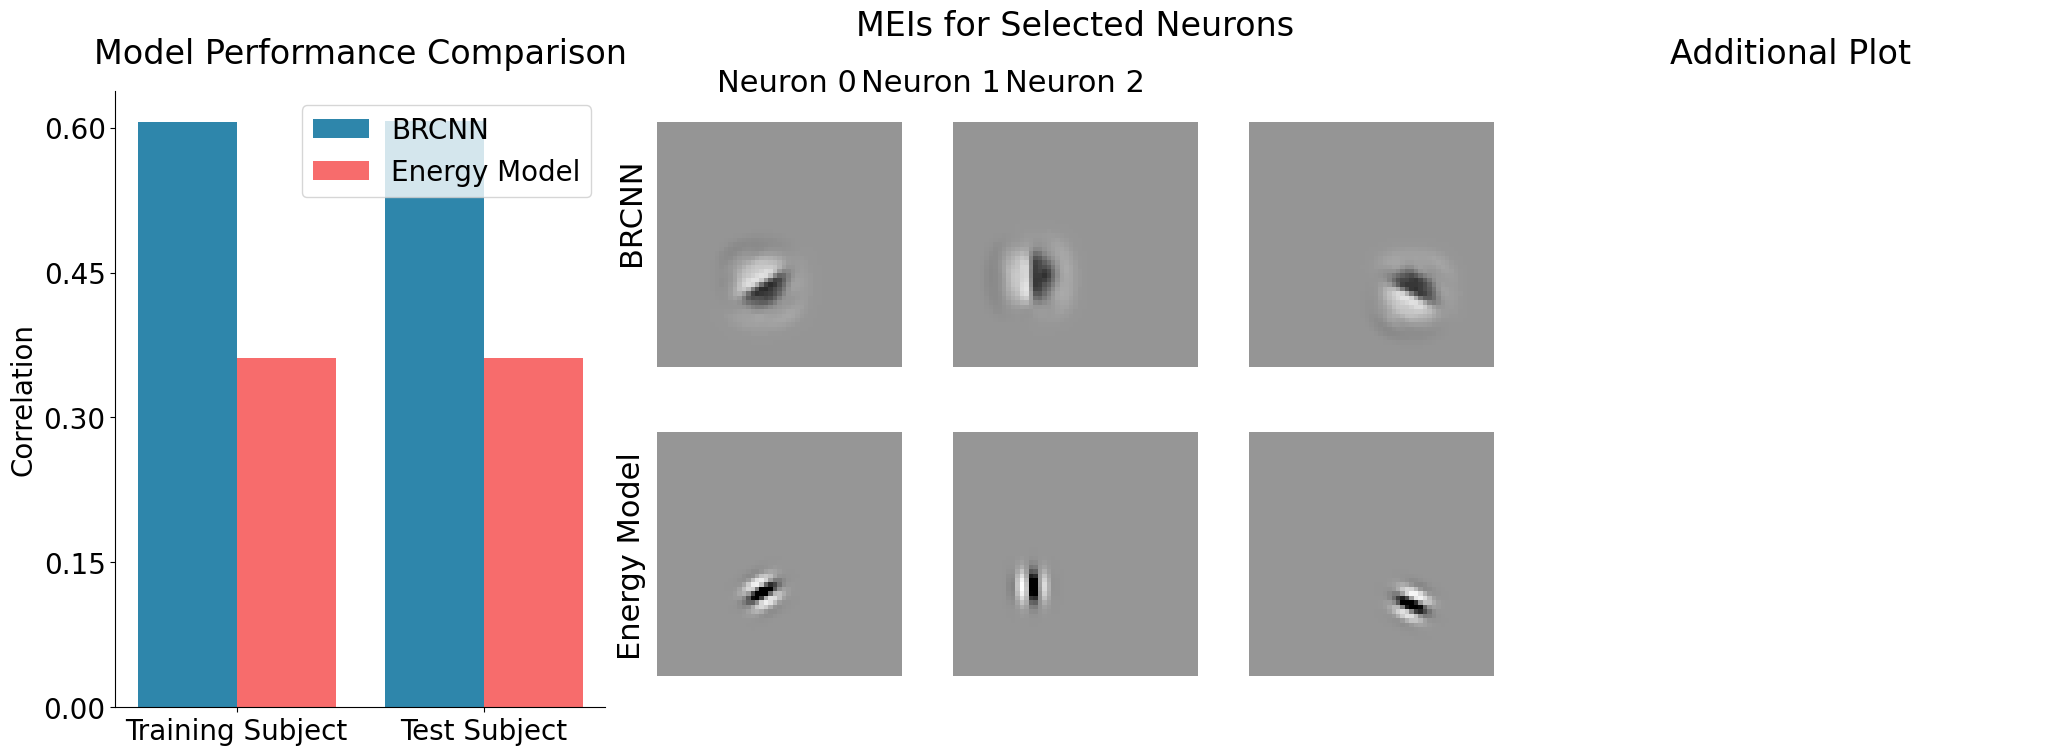

In [52]:
#### model performanc comparison plot
# Create a figure with 2 rows and 5 columns, with the first and last columns spanning both rows
fig = plt.figure(figsize=(24, 8))  # Increased figure size

# Create a grid layout with wider left column and more space for labels
gs = plt.GridSpec(2, 5, figure=fig, width_ratios=[2, 1, 1, 1, 2], left=0.1, right=0.9, 
                 wspace=0.05, hspace=0.01)  # Reduced wspace for tighter spacing

# Add minimal spacing after first column
gs.update(wspace=0.15, hspace=0.01)  # Reduced wspace
gs.get_grid_positions(fig)[1][0] += 0.02  # Reduced shift

# Create the left plot spanning both rows
ax_left = fig.add_subplot(gs[:, 0])  # Spans both rows in first column
width = 0.4
x = np.arange(2)

ax_left.bar(x - width/2, [corr_0_brcnn, corr_1_brcnn], width, label='BRCNN', color='#2E86AB')
ax_left.bar(x + width/2, [corr_0_energy, corr_1_energy], width, label='Energy Model', color='#F76C6C')

ax_left.set_xticks(x)
ax_left.set_xticklabels(['Training Subject', 'Test Subject'], fontsize=20)
ax_left.set_ylabel('Correlation', fontsize=20)
ax_left.legend(fontsize=20)
ax_left.set_title('Model Performance Comparison', fontsize=24, pad=20)
ax_left.tick_params(axis='both', which='major', labelsize=20)

# Remove top and right spines
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)

# Reduce number of y-axis ticks
ax_left.yaxis.set_major_locator(plt.MaxNLocator(5))

# Add column titles for MEIs with adjusted position and larger font
plt.figtext(0.5, 0.95, 'MEIs for Selected Neurons', fontsize=24, ha='center')
for i in range(3):
    plt.figtext(0.38 + i*0.06, 0.88, f'Neuron {i}', fontsize=22, ha='center')  # Further reduced spacing between titles

# Create the MEI plots in the middle 3 columns
for i in range(3):
    # Bottom row MEIs (Energy model)
    ax = fig.add_subplot(gs[1, i+1])
    if i == 0:  # Add row title for Energy model
        plt.figtext(0.315, 0.30, 'Energy Model', fontsize=22, rotation=90, va='center', ha='center')
    ax.imshow(meis_energy[i], cmap='Greys_r', vmin=-v_half, vmax=v_half)
    ax.axis('off')
    
    # Top row MEIs (BRCNN)
    ax = fig.add_subplot(gs[0, i+1])
    if i == 0:  # Add row title for BRCNN
        plt.figtext(0.315, 0.73, 'BRCNN', fontsize=22, rotation=90, va='center', ha='center')
    ax.imshow(meis_brcnn[i], cmap='Greys_r', vmin=pixel_min, vmax=pixel_max)
    ax.axis('off')

# Create the right plot spanning both rows
ax_right = fig.add_subplot(gs[:, -1])  # Spans both rows in last column
ax_right.set_title('Additional Plot', fontsize=24, pad=20)
ax_right.axis('off')  # Placeholder - add additional plot here

plt.show()


# get size tuning curves

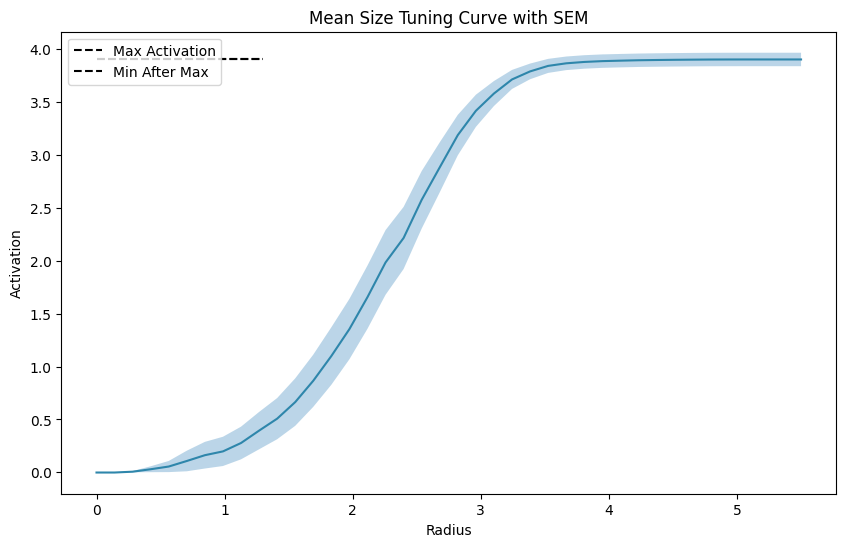

: 

In [58]:
# Path to your HDF5 file
file_path = '/home/baroni/recnn/LSV1M_training/check_LSV1M_model/new_results_LSV1M_model_new_model.h5'

# Open the HDF5 file in read mode
with h5py.File(file_path, 'r') as h5file:
    # Check if the 'size_tuning/curves' group exists
    if 'size_tuning/curves' in h5file:
        group = h5file['size_tuning/curves']
        
        # Store data for all neurons
        all_data = []
        
        # Iterate over neurons
        for neuron_id in range(0,25):
            dataset_name = f'neuron_{neuron_id}'
            
            if dataset_name in group:
                dataset = group[dataset_name]
                # Extract the first row
                data = dataset[0, :]
                all_data.append(data)
            else:
                print(f"Dataset '{dataset_name}' not found in 'size_tuning/curves'.")
        
        # Convert to numpy array
        all_data = np.array(all_data)
        
        # Calculate mean and standard error
        mean_data = np.mean(all_data, axis=0)
        sem_data = np.std(all_data, axis=0) / np.sqrt(len(all_data))
        
        # Store mean and SEM in variables for later use
        size_tuning_mean = mean_data
        size_tuning_sem = sem_data
        
        # Find max value and index
        max_idx = np.argmax(mean_data)
        max_val = mean_data[max_idx]
        
        # Find minimum value after maximum
        min_after_max = np.min(mean_data[max_idx:])
        
        # Plot mean with shaded error using seaborn
        plt.figure(figsize=(10,6))
        sns.lineplot(x=radii, y=mean_data, color='#2E86AB')  # Rich blue for main line
        plt.fill_between(radii, mean_data-sem_data, mean_data+sem_data, alpha=0.3)  # Light blue for shading
        plt.hlines(y=max_val, xmin=0, xmax=1.3, color='black', linestyle='--', label='Max Activation')  # Dark navy
        plt.hlines(y=min_after_max, xmin=0, xmax=1.3, color='black', linestyle='--', label='Min After Max')  # Coral red
        plt.xlabel('Radius')
        plt.ylabel('Activation')
        plt.title('Mean Size Tuning Curve with SEM')
        # plt.xlim(0, 11)
        plt.legend()
        plt.show()
    else:
        print("'size_tuning/curves' group not found in the file.")

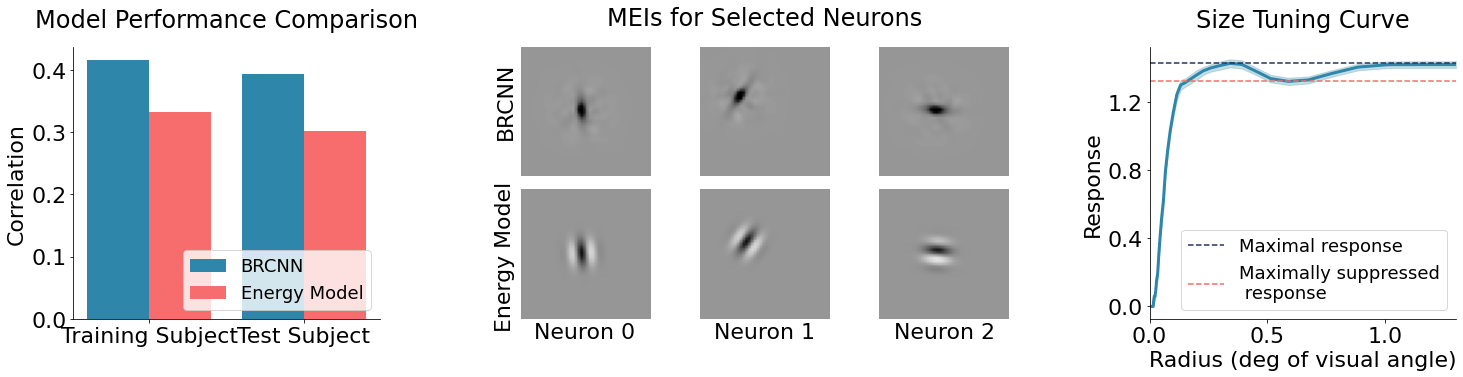

In [136]:
#### model performanc comparison plot
# Create a figure with 2 rows and 7 columns, with the first and last columns spanning both rows
fig = plt.figure(figsize=(24, 5))  # Increased figure size

# Create a grid layout with wider left column and more space for labels
gs = plt.GridSpec(2, 7, figure=fig, width_ratios=[2, 0.5, 1, 1, 1, 0.5, 2], left=0.1, right=0.9, 
                 wspace=0.15, hspace=0.1)  # Reduced spacing between MEIs

# Create the left plot spanning both rows
ax_left = fig.add_subplot(gs[:, 0])  # Spans both rows in first column
width = 0.4
x = np.arange(2)

ax_left.bar(x - width/2, [corr_0_brcnn, corr_1_brcnn], width, label='BRCNN', color='#2E86AB')
ax_left.bar(x + width/2, [corr_0_energy, corr_1_energy], width, label='Energy Model', color='#F76C6C')

ax_left.set_xticks(x)
ax_left.set_xticklabels(['Training\nsubject', 'Test\nsubject'], fontsize=22)
ax_left.set_ylabel('Correlation', fontsize=22)
ax_left.legend(fontsize=18, loc='lower right')
ax_left.set_title('Model Performance Comparison', fontsize=24, pad=20)
ax_left.tick_params(axis='both', which='major', labelsize=22)

# Remove top and right spines
ax_left.spines['top'].set_visible(False)
ax_left.spines['right'].set_visible(False)

# Reduce number of y-axis ticks
ax_left.yaxis.set_major_locator(plt.MaxNLocator(5))

# Add column titles for MEIs with adjusted position and larger font
plt.figtext(0.5, 0.94, 'MEIs for Selected Neurons', fontsize=24, ha='center')
for i in range(3):
    plt.figtext(0.396 + i*0.104,  0.07, f'Neuron {i}', fontsize=22, ha='center')  # Adjusted position

# Create empty subplot after left plot
ax_empty1 = fig.add_subplot(gs[:, 1])
ax_empty1.axis('off')

# Create the MEI plots in the middle 3 columns
for i in range(3):
    # Bottom row MEIs (Energy model)
    ax = fig.add_subplot(gs[1, i+2])
    if i == 0:  # Add row title for Energy model
        plt.figtext(0.35, 0.30, 'Energy Model', fontsize=22, rotation=90, va='center', ha='center')
    ax.imshow(meis_energy[i], cmap='Greys_r', vmin=-v_half, vmax=v_half)
    ax.axis('off')
    
    # Top row MEIs (BRCNN)
    ax = fig.add_subplot(gs[0, i+2])
    if i == 0:  # Add row title for BRCNN
        plt.figtext(0.35, 0.73, 'BRCNN', fontsize=22, rotation=90, va='center', ha='center')
    ax.imshow(brcnn_meis[i], cmap='Greys_r', vmin=-1.7876, vmax=2.1919)
    ax.axis('off')

# Create empty subplot before right plot
ax_empty2 = fig.add_subplot(gs[:, 5])
ax_empty2.axis('off')

# Create the right plot spanning both rows for size tuning curve
ax_right = fig.add_subplot(gs[:, -1])  # Spans both rows in last column
ax_right.set_title('Size Tuning Curve', fontsize=24, pad=20)

# Plot size tuning curve
sns.lineplot(x=radii, y=size_tuning_mean, color='#2E86AB', ax=ax_right, linewidth=3)  # Rich blue for main line, increased width
ax_right.fill_between(radii, size_tuning_mean-size_tuning_sem, size_tuning_mean+size_tuning_sem, 
                     alpha=0.4, color='#6FACC0')  # Darker blue for shading

# Add horizontal lines for max and min after max
max_val = np.max(size_tuning_mean)
max_idx = np.argmax(size_tuning_mean)
min_after_max = np.min(size_tuning_mean[max_idx:])

ax_right.hlines(y=max_val, xmin=0, xmax=1.3, color='#24305E', 
               linestyle='--', label='Maximal response')  # Dark max
ax_right.hlines(y=min_after_max, xmin=0, xmax=1.3, color='#F76C6C', 
               linestyle='--', label='Maximally suppressed\n response')  # Coral red

ax_right.set_xlabel('Radius (deg of visual angle)', fontsize=22)
ax_right.set_ylabel('Response', fontsize=22)
ax_right.tick_params(axis='both', which='major', labelsize=22)
ax_right.set_xlim(0, 1.3)
ax_right.legend(fontsize=18,  loc='lower right')

# Remove top and right spines
ax_right.spines['top'].set_visible(False)
ax_right.spines['right'].set_visible(False)

# Reduce number of y-axis ticks for size tuning plot
ax_right.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.savefig('figure2.svg', format='svg', bbox_inches='tight')
plt.show()


In [ ]:

print(get_avg_correlations(energy_model, dataloaders0['test'], as_dict=False, per_neuron=False))

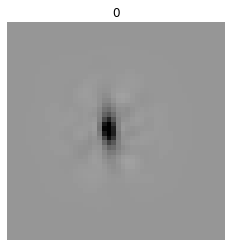

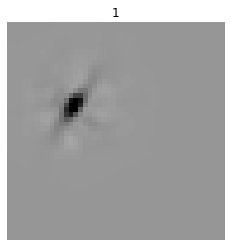

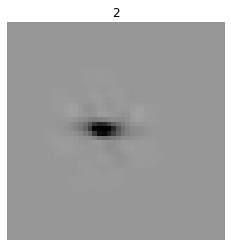

In [15]:
meis = np.load('/project/monkey_training/meis.npy')
for i in range(3):
    plt.imshow(meis[i], cmap='Greys_r', vmin = -1.7876, vmax = 2.1919)
    plt.axis('off')
    plt.title(i)
    plt.show()
